## Results of point pollution diesel spill scenarios at Active Pass
Plotting functions for comparing survival and recovery of groups of species within a single model scenario from the Salish Sea Atlantis Model

In [1]:
import os
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import ssam_groups as groups
import ssam_plot as splot

### Define scenario and control files

In [3]:
# Read in salish sea atlantis output files.
control_file = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/control_v6666mod/outputSalishSea.nc"
scenario1_file = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/Scenario_4a_2019-07-10/outputSalishSea.nc"
scenario2_file = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/Scenario_4a_2019-07-16/outputSalishSea.nc"
scenario3_file = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/Scenario_4a_2020-07-12/outputSalishSea.nc"
scenario4_file = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/Scenario_4a_2020-07-20/outputSalishSea.nc"

control = xr.open_dataset(str(control_file), decode_cf=True)
scenario1 = xr.open_dataset(str(scenario1_file), decode_cf=True)
scenario2 = xr.open_dataset(str(scenario2_file), decode_cf=True)
scenario3 = xr.open_dataset(str(scenario3_file), decode_cf=True)
scenario4 = xr.open_dataset(str(scenario4_file), decode_cf=True)

scenarios = [scenario1, scenario2, scenario3, scenario4]

t = np.ma.filled(control.variables['t'], np.nan)


In [9]:
scenarios2019 = [scenario1, scenario2]
scenarios2020 = [scenario3, scenario4]

In [4]:
# start and end time of data display, after burn-in
start = 0
end = t.size-1

time = t[start:end]

spill_start1 = np.datetime64('2019-07-01')
spill_start2 = np.datetime64('2020-07-01')

### Results

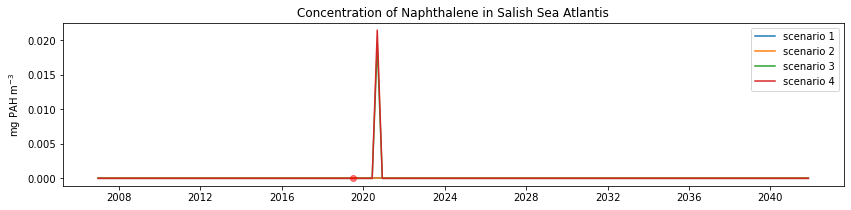

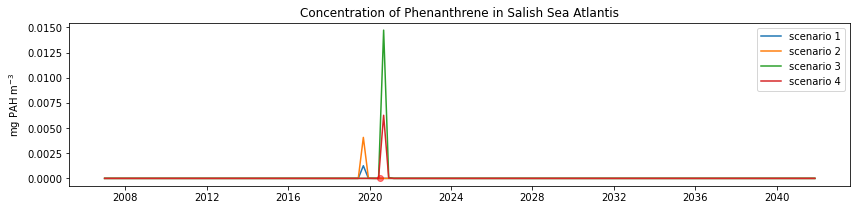

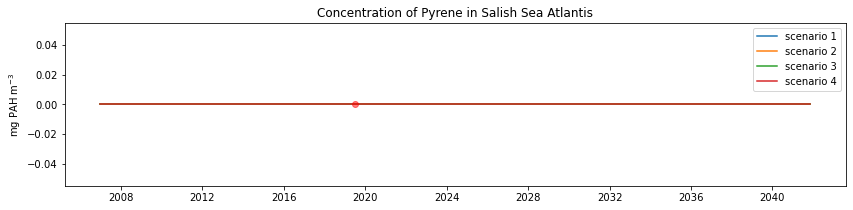

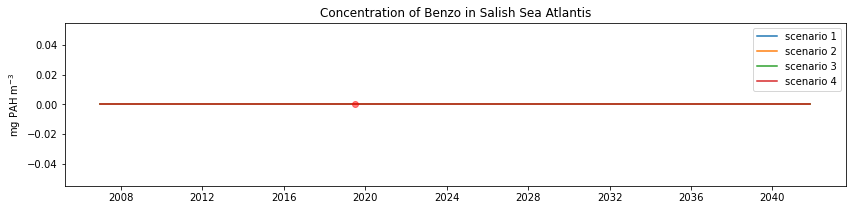

In [6]:
splot.compare_pah('Naphthalene', scenario1, scenario2, scenario3, scenario4, time, start, end, spill_start1)
splot.compare_pah('Phenanthrene', scenario1, scenario2, scenario3, scenario4, time, start, end, spill_start2)
splot.compare_pah('Pyrene', scenario1, scenario2, scenario3, scenario4, time, start, end, spill_start1)
splot.compare_pah('Benzo', scenario1, scenario2, scenario3, scenario4, time, start, end, spill_start1)

Naphthalene in 2019 spills

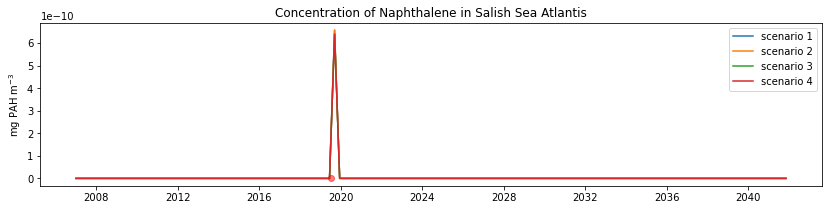

In [7]:
splot.compare_pah('Naphthalene', scenario1, scenario1, scenario2, scenario2, time, start, end, spill_start1)

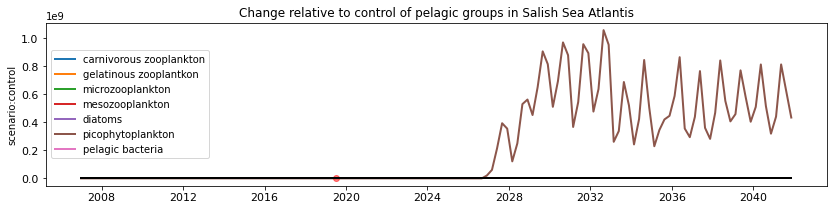

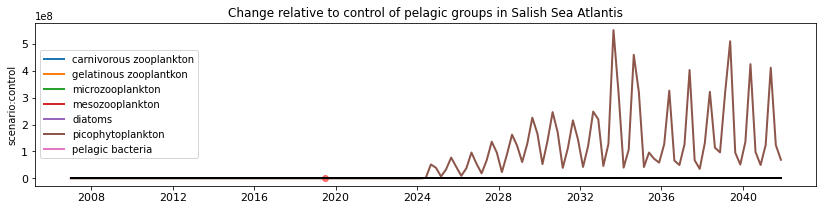

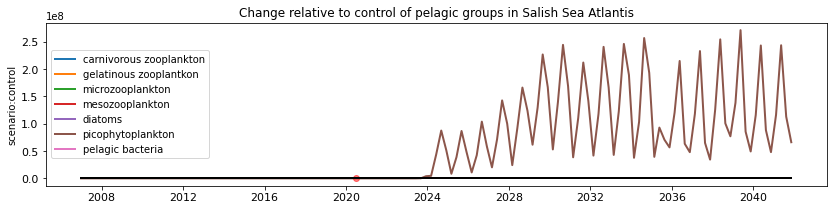

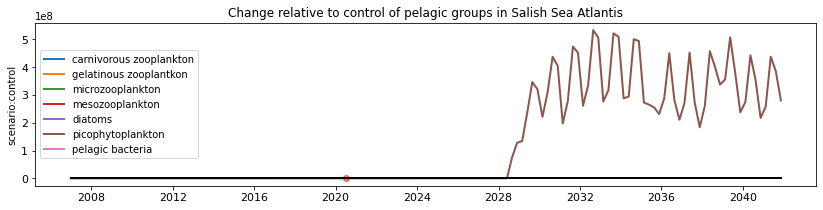

In [11]:
for scenario in scenarios2019:
    splot.plot_pelagic(groups.plankton, scenario, control, time, start, end, spill_start1)

for scenario in scenarios2020:
    splot.plot_pelagic(groups.plankton, scenario, control, time, start, end, spill_start2)

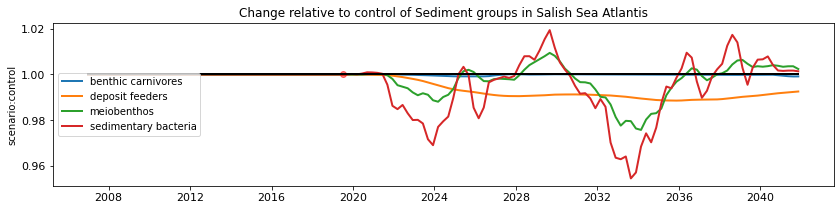

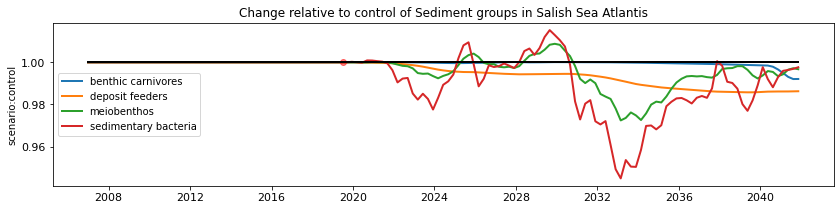

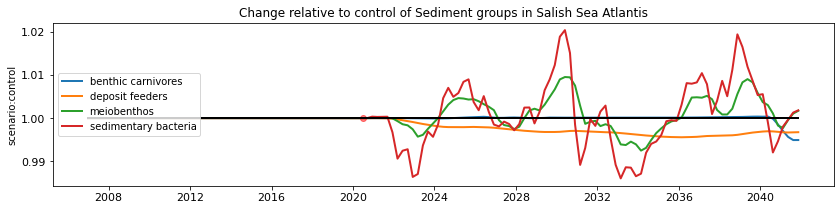

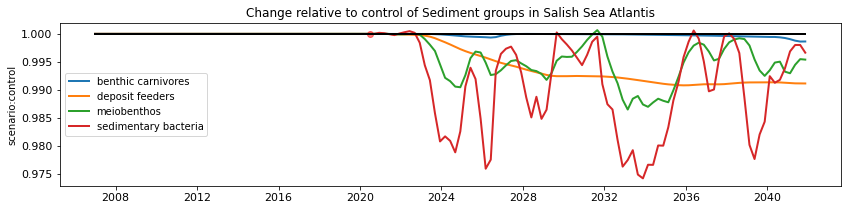

In [10]:
for scenario in scenarios2019:
    splot.plot_sediment(groups.sediment_feeders, scenario, control, time, start, end, spill_start1)

for scenario in scenarios2020:
    splot.plot_sediment(groups.sediment_feeders, scenario, control, time, start, end, spill_start2)

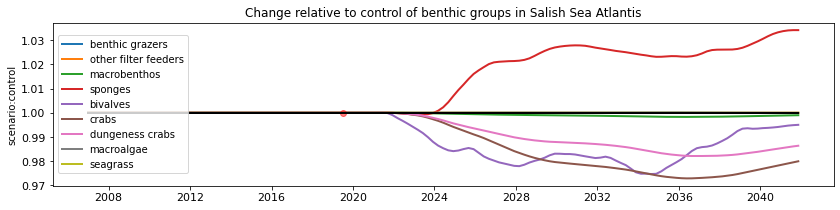

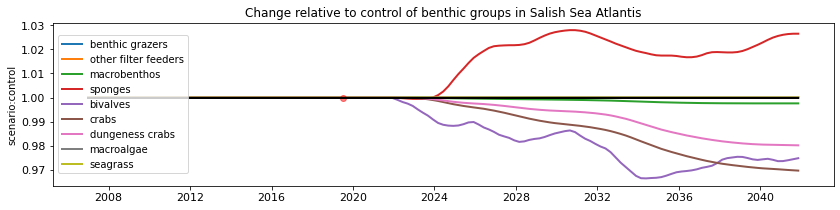

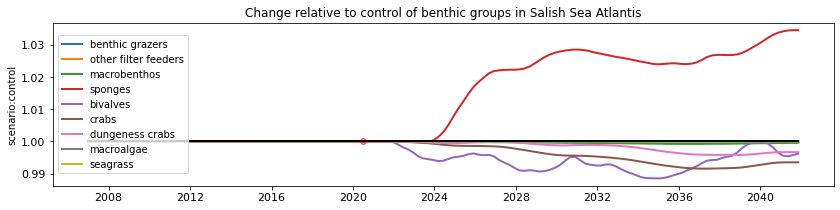

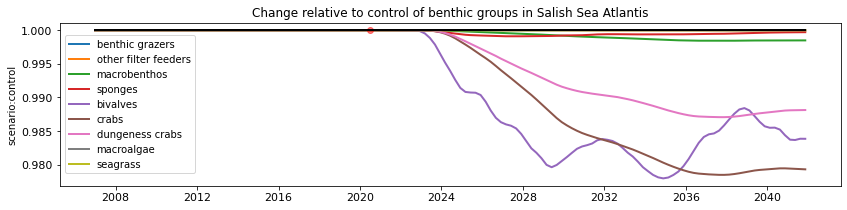

In [12]:
for scenario in scenarios2019:
    splot.plot_benthic(groups.benthos, scenario, control, time, start, end, spill_start1)

for scenario in scenarios2020:
    splot.plot_benthic(groups.benthos, scenario, control, time, start, end, spill_start2)

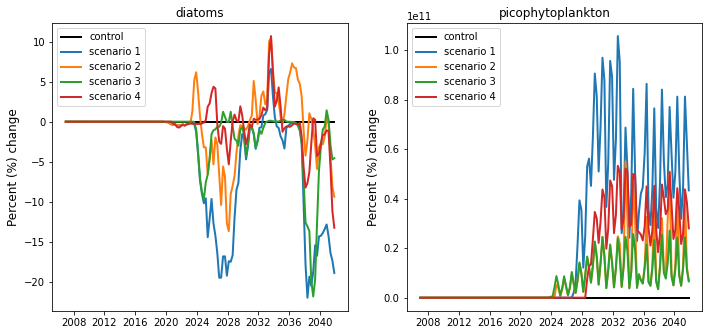

In [13]:
splot.pelagic_compare_scenarios(groups.phytoplankton, scenario1, scenario2, scenario3, scenario4, control, time, start, end)

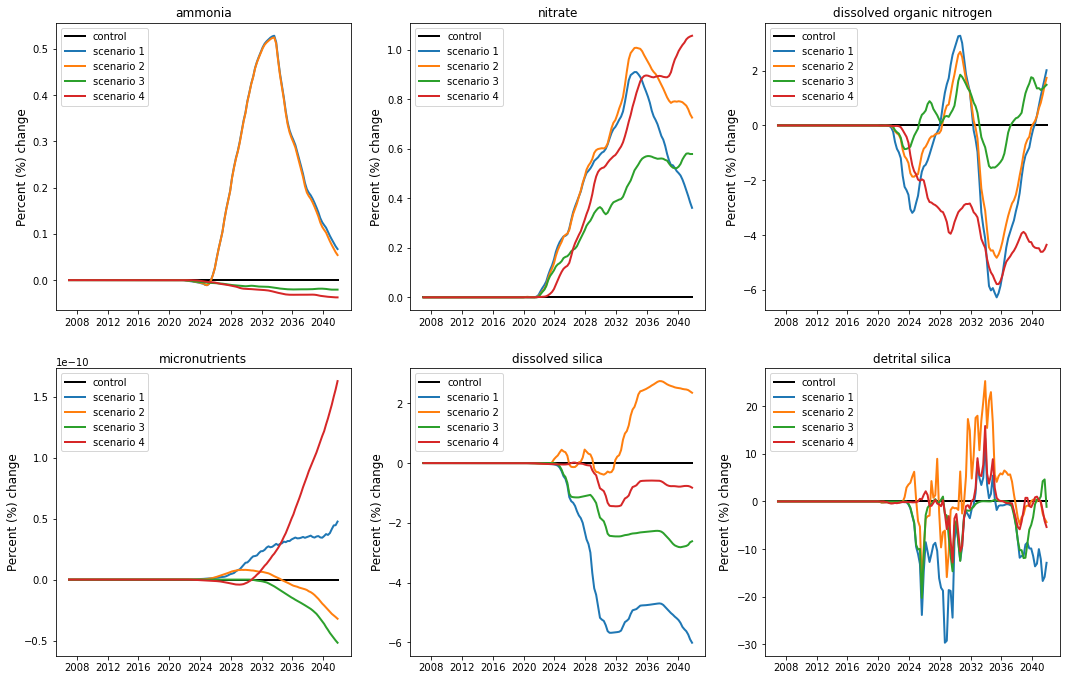

In [19]:
splot.pelagic_compare_nutrients(groups.nutrients, scenario1, scenario2, scenario3, scenario4, control, time, start, end, y_min=None, y_max=None)

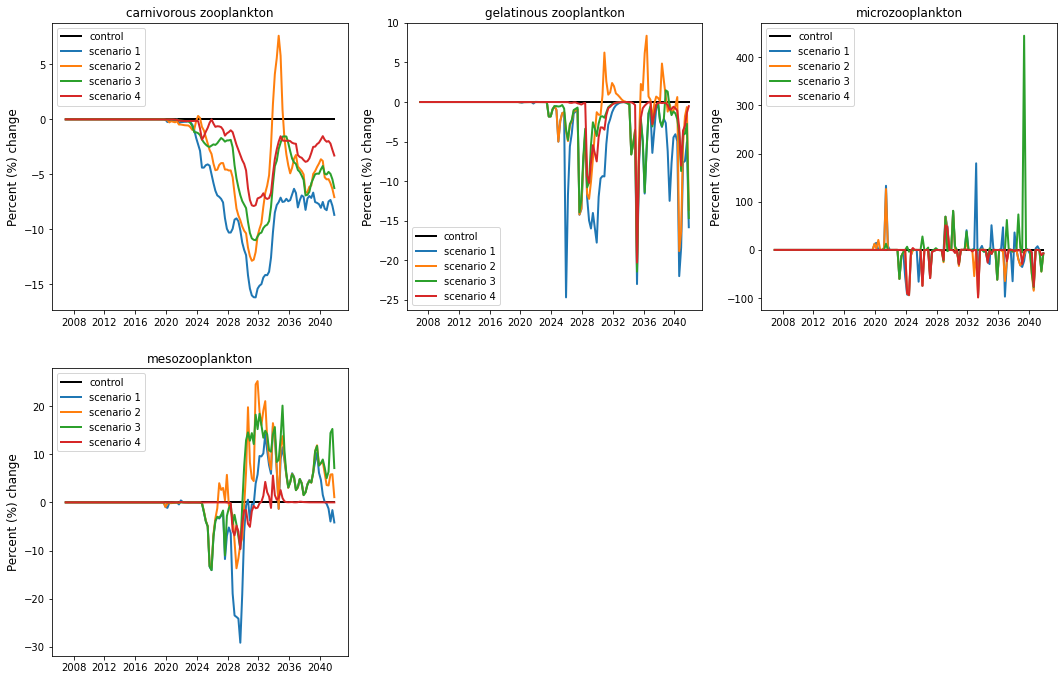

In [14]:
splot.pelagic_compare_scenarios(groups.zooplankton, scenario1, scenario2, scenario3, scenario4, control, time, start, end)

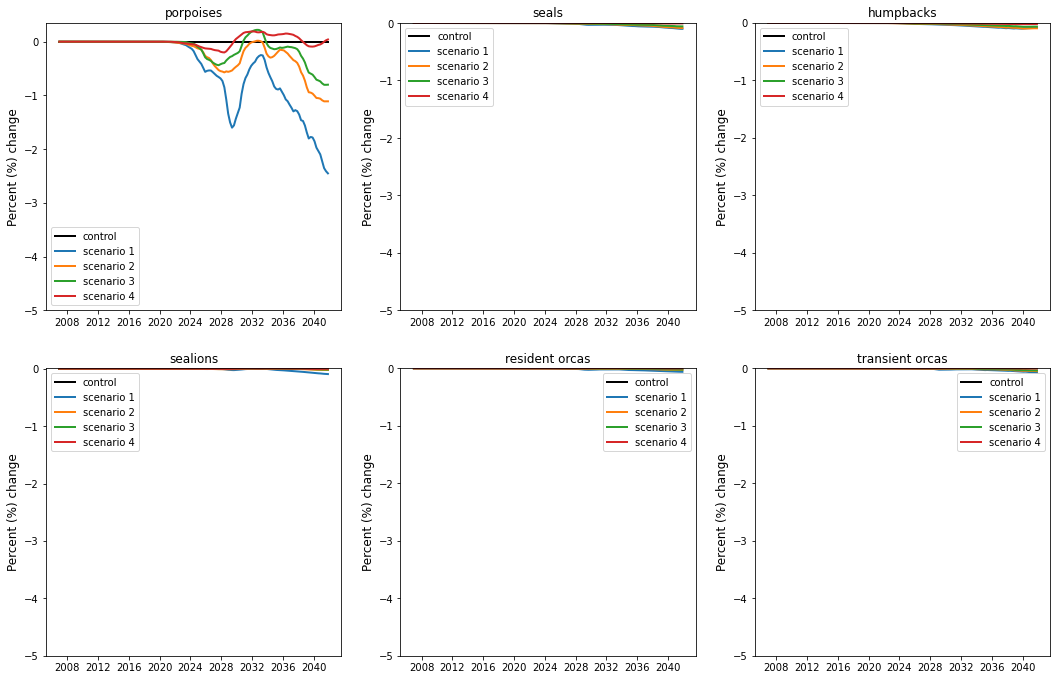

In [17]:
splot.pelagic_compare_scenarios(groups.mammals, scenario1, scenario2, scenario3, scenario4, control, time, start, end, y_min=-5, y_max=None)

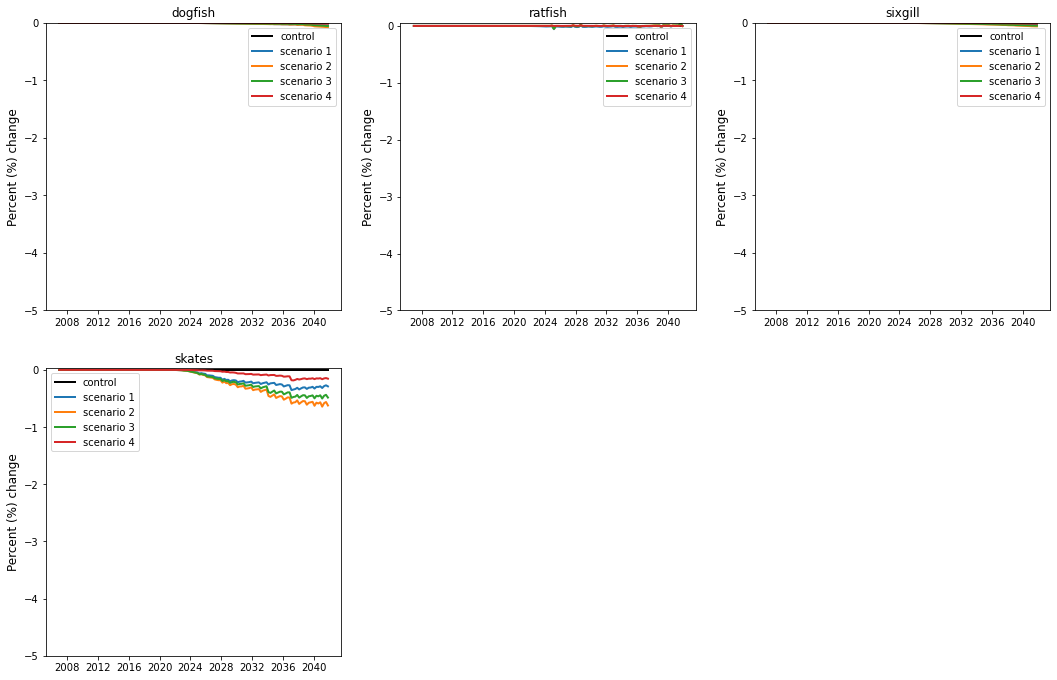

In [18]:
splot.pelagic_compare_scenarios(groups.sharks, scenario1, scenario2, scenario3, scenario4, control, time, start, end, y_min=-5, y_max=None)

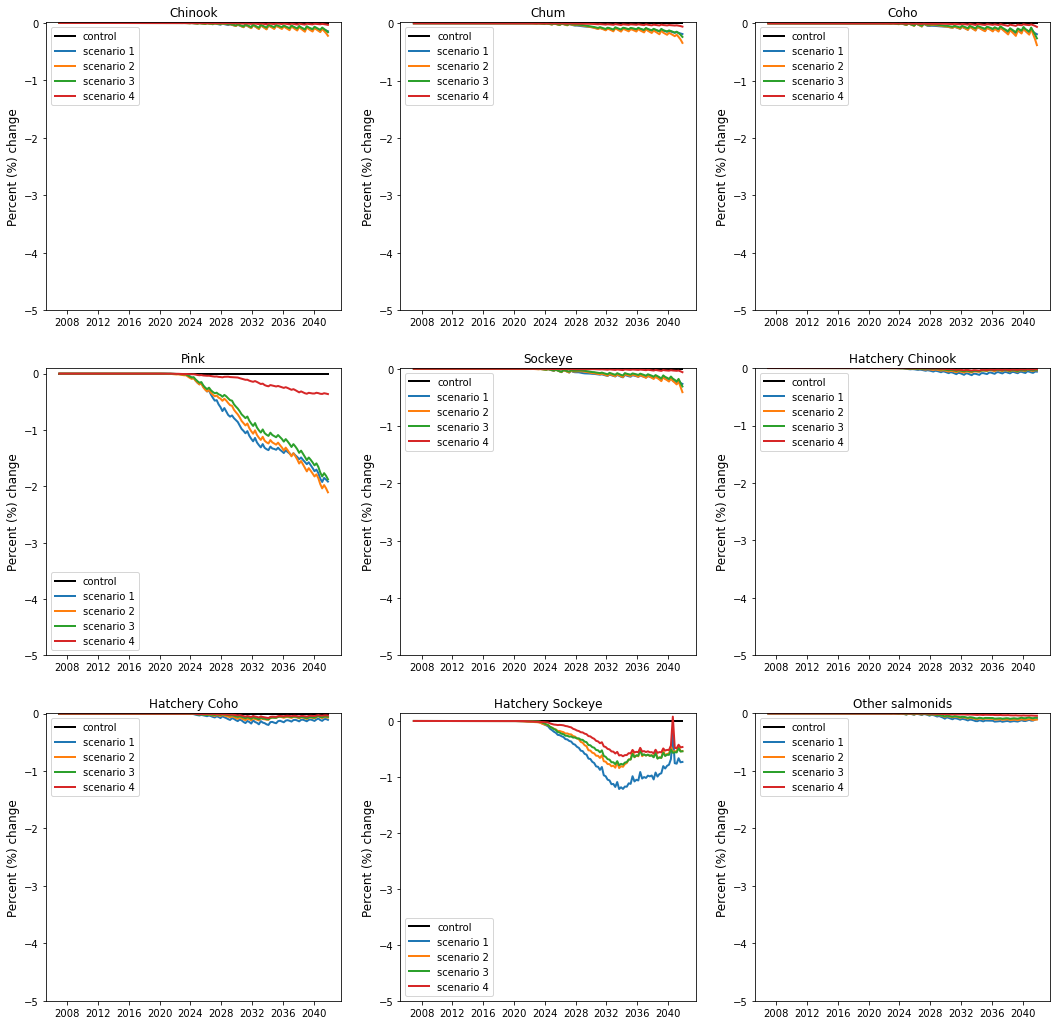

In [20]:
splot.pelagic_compare_scenarios(groups.salmon, scenario1, scenario2, scenario3, scenario4, control, time, start, end, y_min=-5, y_max=None)

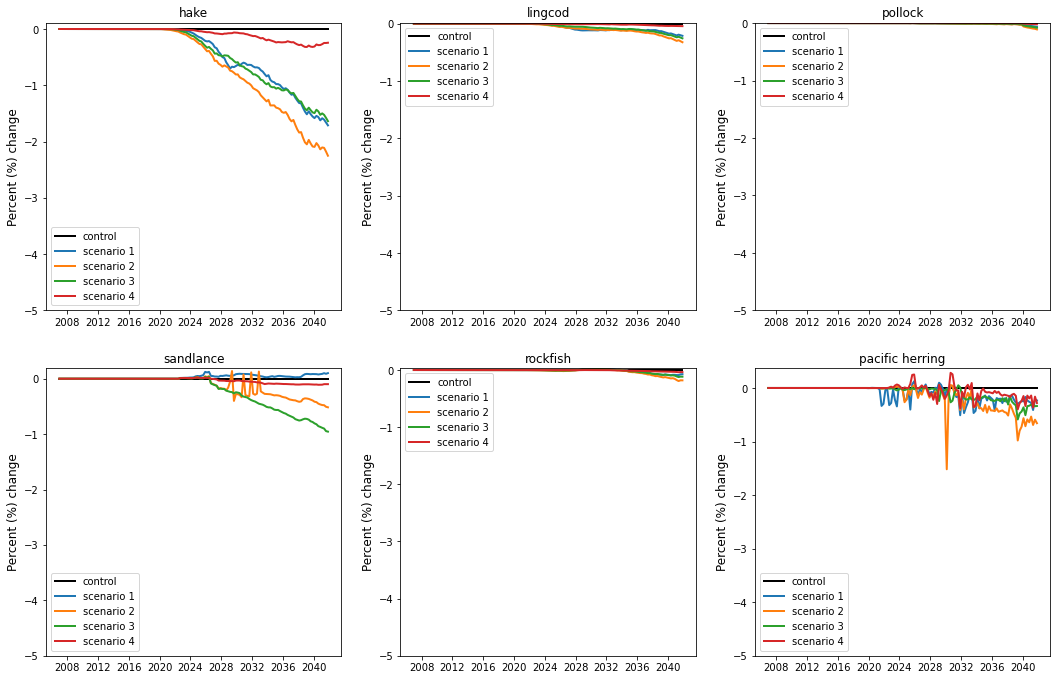

In [21]:
splot.pelagic_compare_scenarios(groups.named_fish, scenario1, scenario2, scenario3, scenario4, control, time, start, end, y_min=-5, y_max=None)

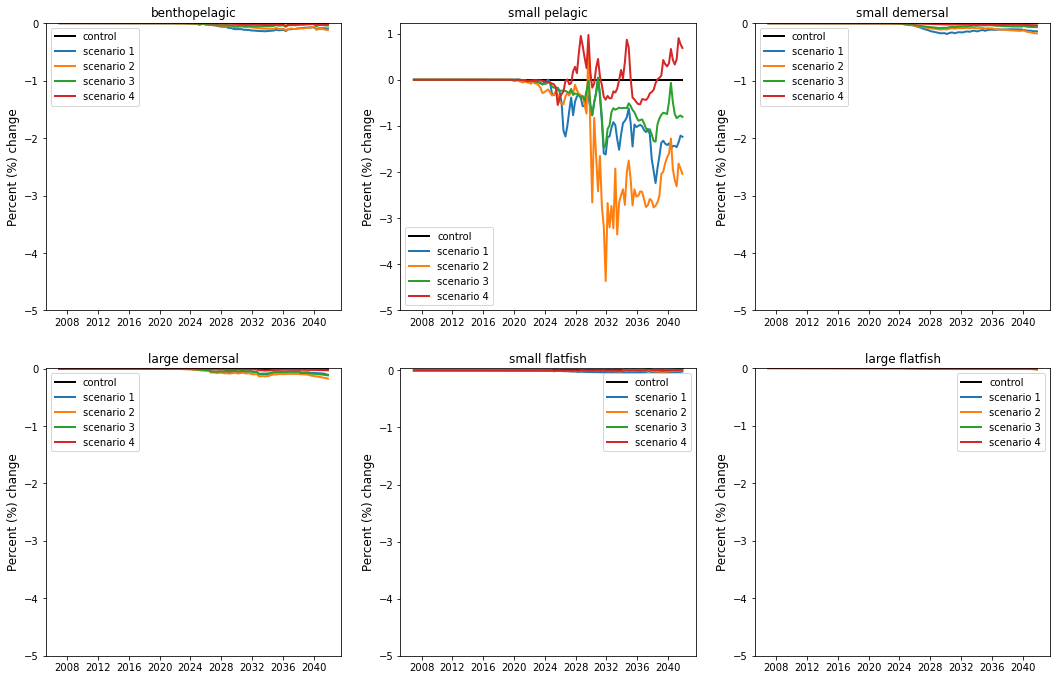

In [22]:
splot.pelagic_compare_scenarios(groups.other_fish, scenario1, scenario2, scenario3, scenario4, control, time, start, end, y_min=-5, y_max=None)

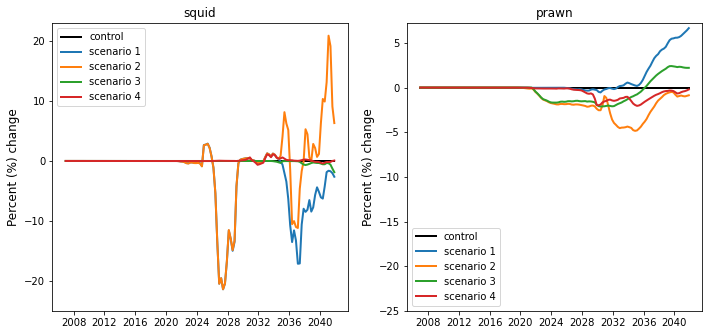

In [23]:
splot.pelagic_compare_scenarios(groups.pelagic_invertebrates, scenario1, scenario2, scenario3, scenario4, control, time, start, end, y_min=-25, y_max=None)

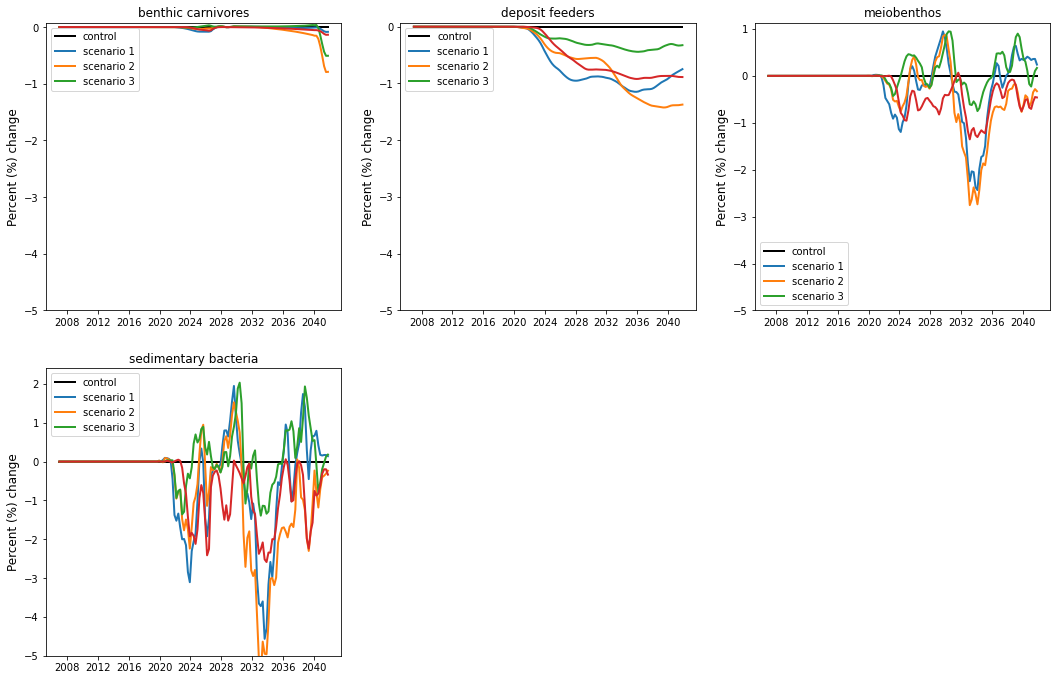

In [24]:
splot.sediment_compare_scenarios(groups.sediment_feeders, scenario1, scenario2, scenario3, scenario4, control, time, start, end, y_min=-5, y_max=None)

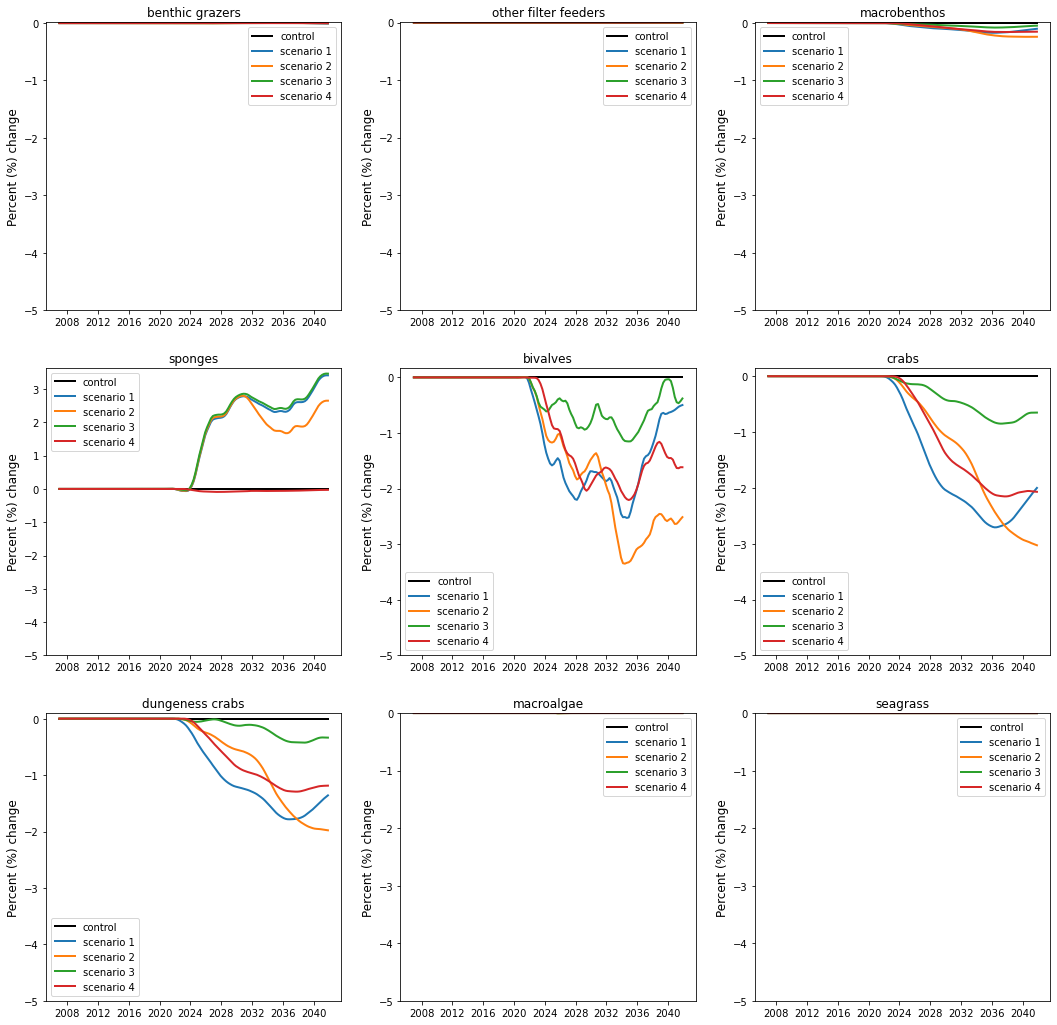

In [25]:
splot.benthic_compare_scenarios(groups.benthos, scenario1, scenario2, scenario3, scenario4, control, time, start, end, y_min=-5, y_max=None)

### Assessing specific periods post-spill

In [26]:
print('closest time points to spill: ' + str(t[51]))
print('5 years post spill: ' + str((t[69])))
print('10 years post spill: ' + str(t[89]))
print('20 years post spill: ' + str(t[129]))

closest time points to spill: 2019-09-11T14:00:00.000000000
5 years post spill: 2024-03-06T14:00:00.000000000
10 years post spill: 2029-02-28T14:00:00.000000000
20 years post spill: 2039-02-16T14:00:00.000000000


In [27]:
days2019summer = [51, 71, 91, 131]
days2020summer = [55, 75, 95, 135]
data_label = {'spill year': [], '5 years later': [], '10 years later': [], '20 years later': []}

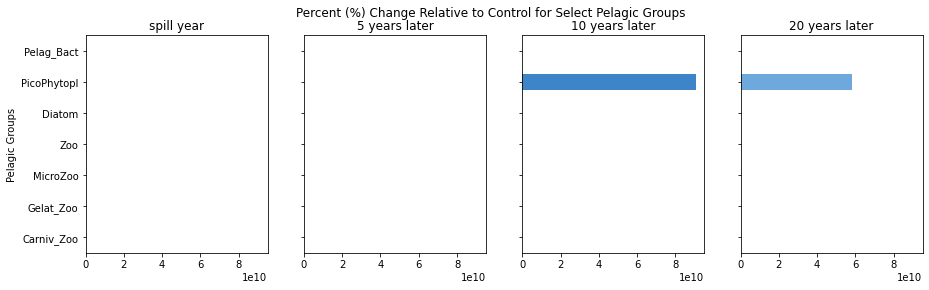

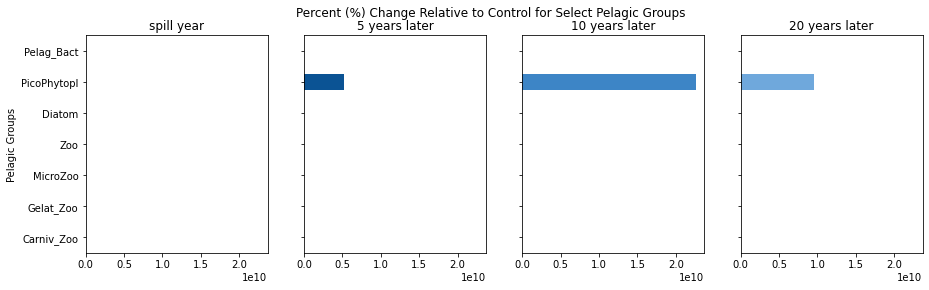

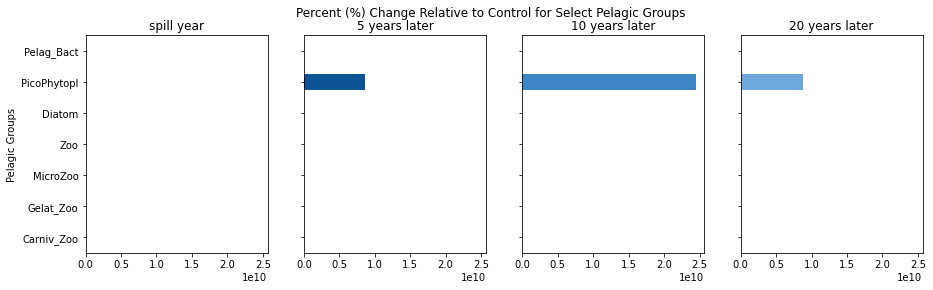

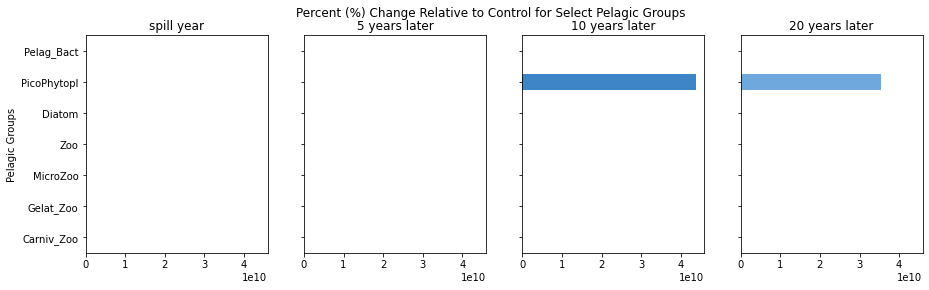

In [28]:
for scenario in scenarios2019:
    splot.boxplot_pelagic(groups.plankton,scenario,control,days2019summer,data_label)

for scenario in scenarios2020:
    splot.boxplot_pelagic(groups.plankton,scenario,control,days2020summer,data_label)

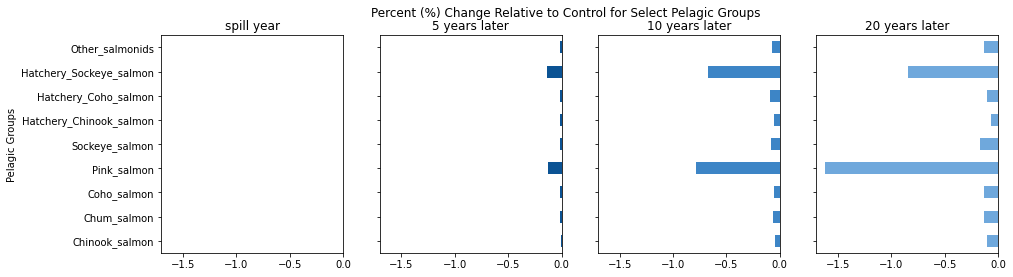

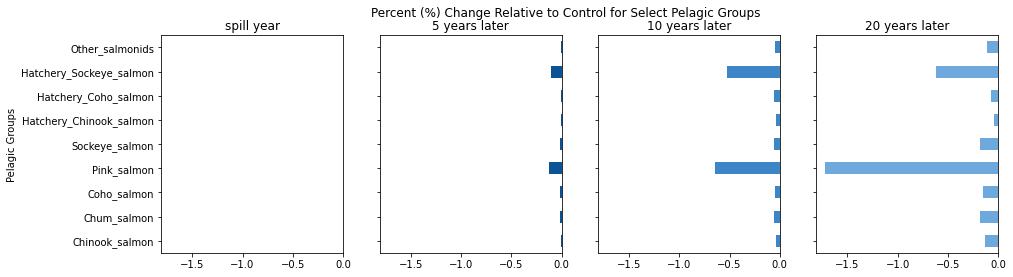

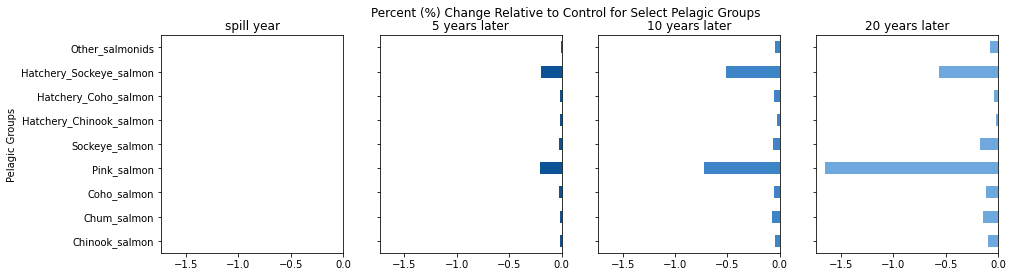

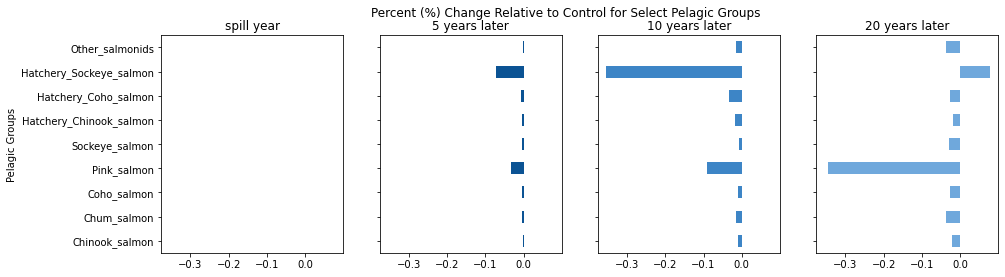

In [29]:
for scenario in scenarios2019:
    splot.boxplot_pelagic(groups.salmon,scenario,control,days2019summer,data_label)

for scenario in scenarios2020:
    splot.boxplot_pelagic(groups.salmon,scenario,control,days2020summer,data_label)

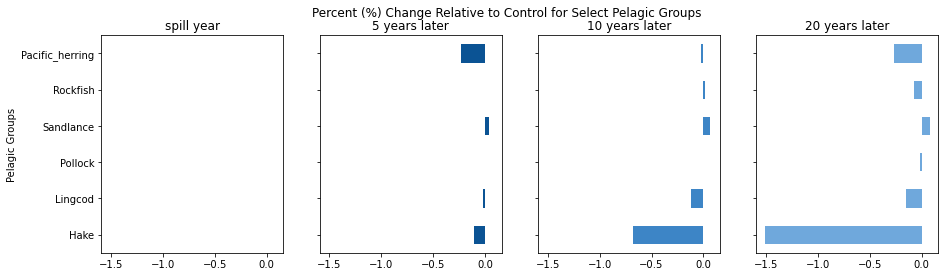

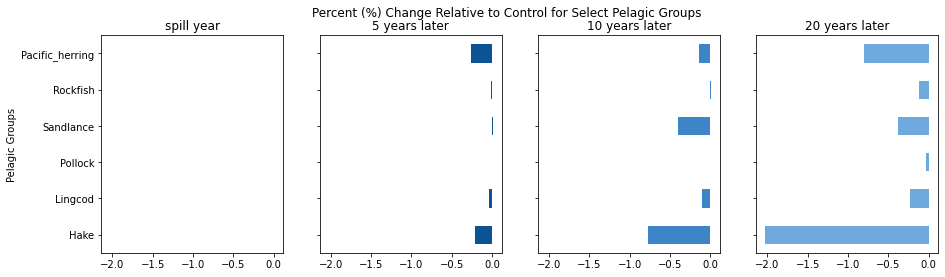

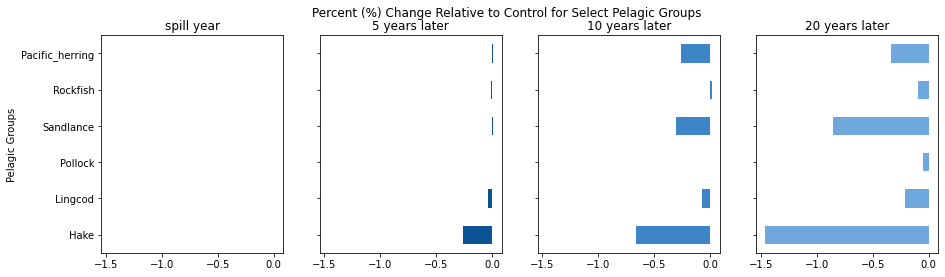

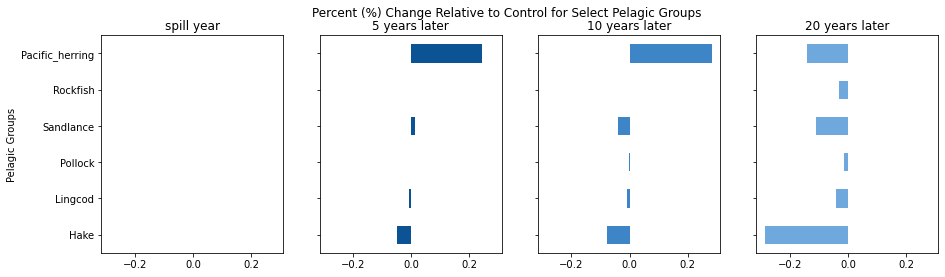

In [30]:
for scenario in scenarios2019:
    splot.boxplot_pelagic(groups.named_fish,scenario,control,days2019summer,data_label)

for scenario in scenarios2020:
    splot.boxplot_pelagic(groups.named_fish,scenario,control,days2020summer,data_label)

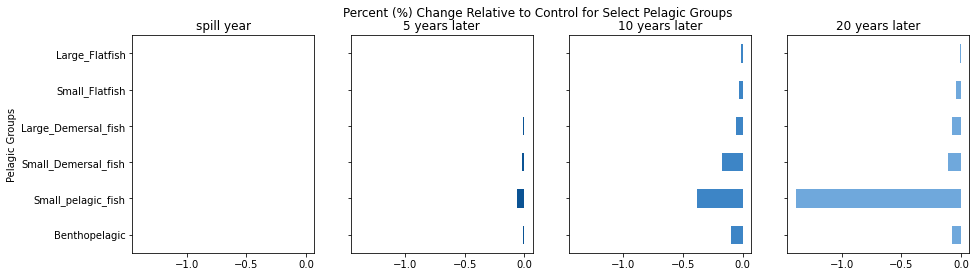

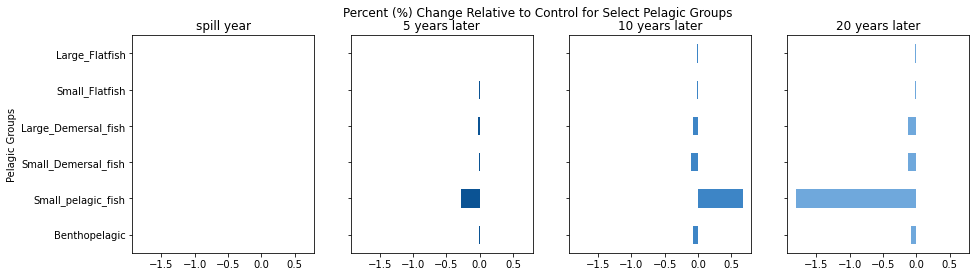

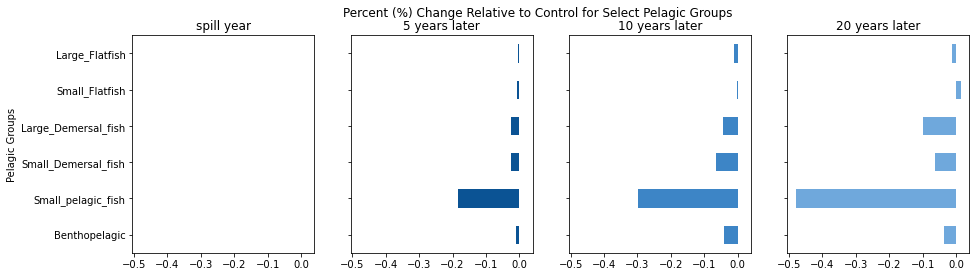

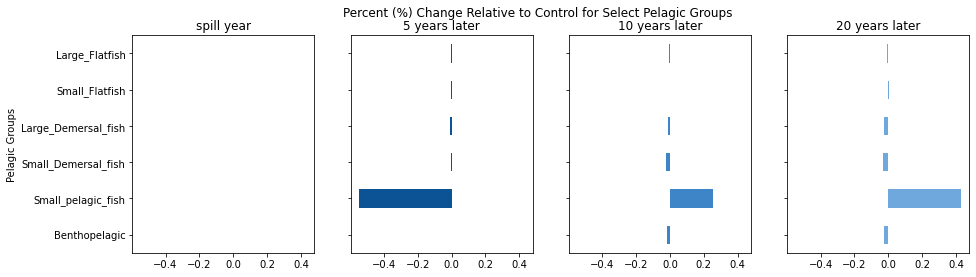

In [31]:
for scenario in scenarios2019:
    splot.boxplot_pelagic(groups.other_fish,scenario,control,days2019summer,data_label)

for scenario in scenarios2020:
    splot.boxplot_pelagic(groups.other_fish,scenario,control,days2020summer,data_label)

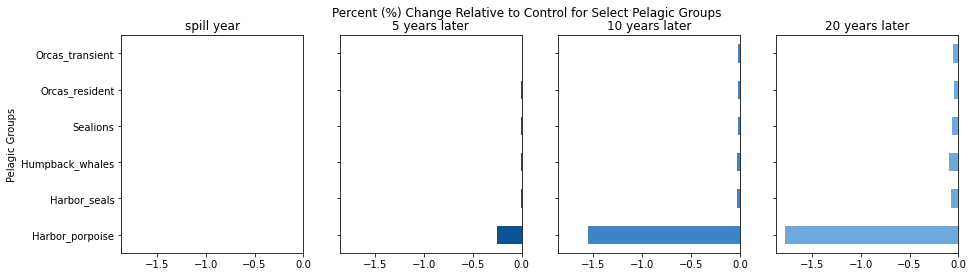

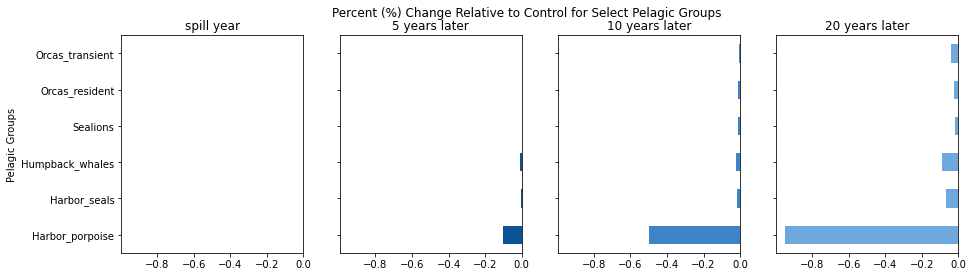

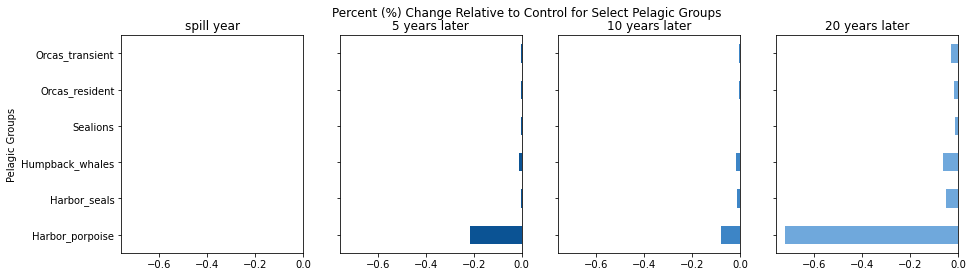

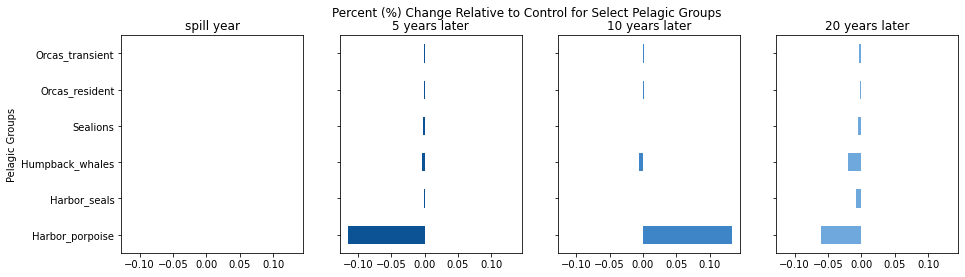

In [32]:
for scenario in scenarios2019:
    splot.boxplot_pelagic(groups.mammals,scenario,control,days2019summer,data_label)

for scenario in scenarios2020:
    splot.boxplot_pelagic(groups.mammals,scenario,control,days2020summer,data_label)

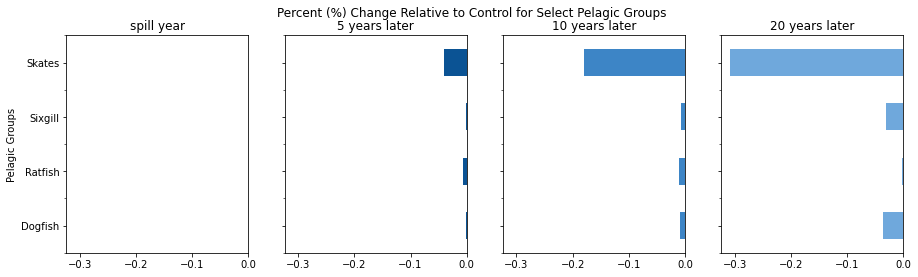

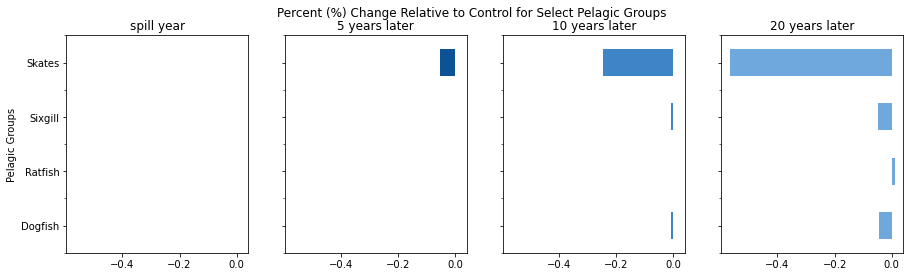

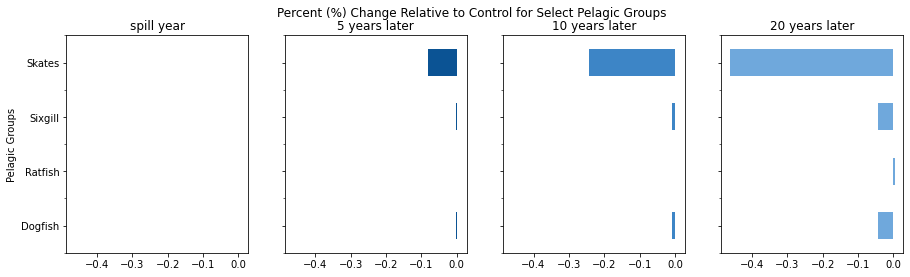

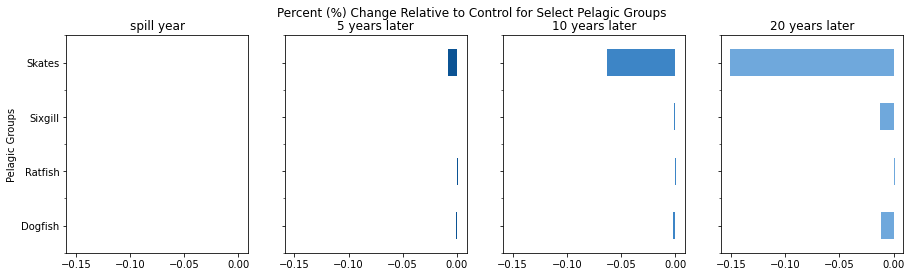

In [33]:
for scenario in scenarios2019:
    splot.boxplot_pelagic(groups.sharks,scenario,control,days2019summer,data_label)

for scenario in scenarios2020:
    splot.boxplot_pelagic(groups.sharks,scenario,control,days2020summer,data_label)